In [2]:
from typing import Dict
from collections import defaultdict

def plot_map_vs_mar_at_steps(
    log_files,
    map_key="coco/bbox_mAP",
    mar_key="coco/bbox_AR@100",
    target_steps=(12, 24, 36),
    step_key_preference="epoch",
    log_labels=None,
    show=True,
    save_path=None,
    dpi=120,
):
    """
    Scatter‑plots mAP (x‑axis) against mAR (y‑axis) for a set of log files.
    Each file contributes one point per *target_step* (e.g. 12, 24, 36).

    Parameters
    ----------
    log_files : sequence of str or Path
        JSON‑lines training/validation logs (one record per line).
    map_key, mar_key : str
        Keys to look up in each JSON line for mAP and mAR.
    target_steps : iterable of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here (any suffix matplotlib supports).
    dpi : int
        DPI for the saved/ shown figure.
    log_labels : list/tuple OR dict OR None
        • If a sequence → must be same length as `log_files`; positional mapping.  
        • If a dict     → keys are full paths or `Path(...).name`, values are labels.  
        • If None       → falls back to Path(file).name.
    """

    from pathlib import Path
    import json, matplotlib.pyplot as plt, numpy as np

    # ---------- helper to resolve a label for a file -------------------------
    def _label_for(idx, f):
        if log_labels is None:
            return Path(f).name
        if isinstance(log_labels, (list, tuple)):
            return log_labels[idx]
        # dict-like
        return log_labels.get(f, log_labels.get(Path(f).name, Path(f).name))

    # ---------- collect points -----------------------------------------------
    target_steps = set(target_steps)
    points = []
    for file_idx, file_path in enumerate(log_files):
        file_path = Path(file_path)
        found: Dict[int, Dict[str, float]] = {s: {} for s in target_steps}

        try:
            with file_path.open() as fh:
                for line in fh:
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    step_val = (
                        rec.get(step_key_preference)
                        or rec.get("epoch")
                        or rec.get("step")
                    )
                    if step_val not in target_steps:
                        continue

                    if map_key in rec:
                        found[step_val][map_key] = rec[map_key]
                    if mar_key in rec:
                        found[step_val][mar_key] = rec[mar_key]

        except FileNotFoundError:
            print(f"[WARN] file not found: {file_path}")
            continue

        for s in sorted(found):
            if map_key in found[s] and mar_key in found[s]:
                points.append(
                    {
                        "map": found[s][map_key],
                        "mar": found[s][mar_key],
                        "step": s,
                        "file_idx": file_idx,
                        "label": file_path.name,
                    }
                )
            else:
                print(
                    f"[WARN] missing {map_key}/{mar_key} at step {s} "
                    f"in {file_path.name}"
                )

    if not points:
        print("[INFO] nothing to plot."); return

    # ---------- plotting -----------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 7), dpi=dpi)
    n_files = len(log_files)
    cmap = plt.cm.get_cmap("viridis", max(n_files, 1))
    unique_steps = sorted(target_steps)
    markers = ["o", "s", "^", "D", "P", "X", "*", "v"]
    marker_for_step = {s: markers[i % len(markers)] for i, s in enumerate(unique_steps)}

    by_file = defaultdict(list)
    for p in points:
        ax.scatter(
            p["map"], p["mar"],
            marker=marker_for_step[p["step"]],
            s=80,
            color=cmap(p["file_idx"] / max(n_files - 1, 1)),
            edgecolors="k", linewidth=0.4, alpha=0.8,
        )
        by_file[p["file_idx"]].append(p)
    
    # draw faint line (and keep the existing scatter/legends that follow)
    for file_idx, pts in by_file.items():
        pts = sorted(pts, key=lambda d: d["step"])       # order 12‑24‑36
        xs  = [p["map"] for p in pts]
        ys  = [p["mar"] for p in pts]

        ax.plot(
            xs,
            ys,
            linestyle="-",
            linewidth=1.0,
            alpha=0.3,          #  ←  faint line
            color=cmap(file_idx / max(n_files - 1, 1)),
            zorder=1,           # behind the markers
        )
        # ─── label AT START of the line ───
        lbl = _label_for(file_idx, log_files[file_idx])

        # compute a small x-offset: 1 % of current x-range
        x_off = -0.01 * (ax.get_xlim()[1] - ax.get_xlim()[0])

        ax.text(xs[0] + x_off,    # start-point − tiny offset
                ys[0],
                lbl,
                fontsize=8,
                fontweight="bold",
                color=cmap(file_idx / max(n_files - 1, 1)),
                va="center",
                ha="right",        # text grows to the left → avoids marker
                alpha=0.9,
                zorder=2,
                clip_on=True)

    # -----------------------------------------------------------------------
    # ░░ Draw iso‑F1 (or Fβ) lines behind everything ░░
    # -----------------------------------------------------------------------
    f_levels = [0.3, 0.4, 0.5, 0.6, 0.7]        # tweak as you like
    xmin, xmax = ax.get_xlim()
    x_vals = np.linspace(xmin, xmax, 400)

    for F in f_levels:
        # domain starts at P = F/2
        p = x_vals[x_vals > F / 2 + 1e-6]
        r = (F * p) / (2 * p - F)

        # keep points that land inside current y‑axis limits
        ymask = (r >= ax.get_ylim()[0]) & (r <= ax.get_ylim()[1])
        ax.plot(
            p[ymask],
            r[ymask],
            linestyle="--",
            linewidth=0.8,
            color="grey",
            alpha=0.4,
            zorder=0,           # far behind markers/lines
        )
        # label the curve on the right edge
        if ymask.any():
            ax.text(
                p[ymask][-1],
                r[ymask][-1],
                f"F1={F:.1f}",
                fontsize=8,
                color="grey",
                ha="left",
                va="center",
                alpha=0.6,
            )

    # # -------- legend by file (colours) -----------------------------------------
    # file_handles = [
    #     plt.Line2D([0], [0], marker="o", linestyle="", markersize=8,
    #             markerfacecolor=cmap(i / max(n_files - 1, 1)),
    #             markeredgecolor="k")
    #     for i in range(n_files)
    # ]
    # file_labels = [_label_for(i, f) for i, f in enumerate(log_files)]

    # file_legend = ax.legend(  # keep a reference!
    #     file_handles,
    #     file_labels,
    #     title="log file",
    #     loc="upper left",
    #     fontsize="small",
    # )
    # ax.add_artist(file_legend)   # ← tells matplotlib to draw *and keep* this legend


    # -------- legend by step (markers) -----------------------------------------
    step_handles = [
        plt.Line2D([0], [0], marker=marker_for_step[s], linestyle="",
                markersize=8, color="w", markeredgecolor="k")
        for s in unique_steps
    ]
    step_labels = [f"step {s}" for s in unique_steps]

    ax.legend(
        step_handles,
        step_labels,
        title="epoch step",
        loc="lower right",
        fontsize="small",
    )
    ax.set_xlabel(map_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_ylabel(mar_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"mAP vs mAR at steps {', '.join(map(str, unique_steps))}")
    ax.grid(True, linestyle="--", alpha=0.6)
    fig.tight_layout()

    if save_path: 
        fig.savefig(save_path, dpi=dpi)
    if show: 
        plt.show()
    else:
        plt.close(fig)


[WARN] missing coco/bbox_mAP/coco/bbox_AR@100 at step 12 in scalars.json
[WARN] missing coco/bbox_mAP/coco/bbox_AR@100 at step 24 in scalars.json
[WARN] missing coco/bbox_mAP/coco/bbox_AR@100 at step 36 in scalars.json


/tmp/ipykernel_52229/892659445.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", max(n_files, 1))


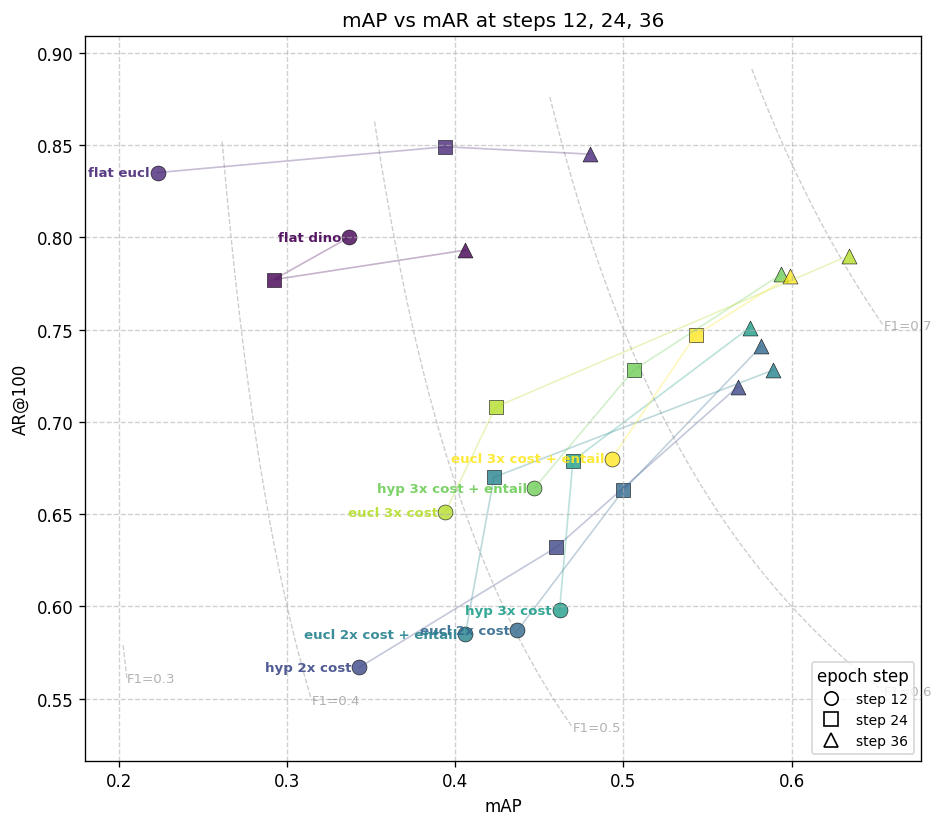

In [6]:
log_file_paths = [
    "../work_dirs/dino-4scale_r50-linear_improved_8xb2/20250428_044942/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50-shared-proj_improved_8xb2/20250427_071406/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-hyp-2x/20250513_195813/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-2x/20250508_162122/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-2x-entail/20250510_095737/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-hyp-3x/20250514_140310/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_share-hyp_hfl-3x_hcl_improved_8xb2_hier-aircraft/20250516_145352/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-hyp-3x-entail/20250515_083637/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x/20250512_012240/vis_data/scalars.json",
    "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-entail-full/20250511_071356/vis_data/scalars.json"
]

custom_labels = [
    "flat dino",
    "flat eucl",
    "hyp 2x cost",
    "eucl 2x cost",
    "eucl 2x cost + entail",
    "hyp 3x cost",
    "hyp 3x + hfl + hcl",
    "hyp 3x cost + entail",
    "eucl 3x cost",
    "eucl 3x cost + entail",
]
plot_map_vs_mar_at_steps(
    log_file_paths,
    map_key="coco/bbox_mAP",
    mar_key="coco/bbox_AR@100",
    target_steps=[12, 24, 36],
    log_labels=custom_labels,
)


In [ ]:
from typing import Dict, List, Tuple, Union, Sequence, Optional
from collections import defaultdict
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

def plot_f1_comparison(
    experiment_dirs: Sequence[Union[str, Path]],
    f1_key: str = "coco/bbox_mF1",
    target_steps: Tuple[int, ...] = (12, 24, 36),
    step_key_preference: str = "epoch",
    log_labels: Optional[Union[List[str], Dict[Union[str, Path], str]]] = None,
    show: bool = True,
    save_path: Optional[Union[str, Path]] = None,
    dpi: int = 120,
    figsize: Tuple[float, float] = (12, 7),
    bar_width_scale: float = 0.8
):
    """
    Plots F1 scores for a set of experiment directories as a grouped horizontal bar chart.
    For each directory, it calculates the mean and std dev of F1 scores over multiple runs.
    Each group of bars represents an experiment, and each bar within a group
    represents the mean F1 score at a specific target step, with error bars for std dev.

    Parameters
    ----------
    experiment_dirs : sequence of str or Path
        Directories containing experiment runs. Each subdirectory with a timestamp is a run.
    f1_key : str
        Key to look up in each JSON line for F1 score.
    target_steps : tuple of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    log_labels : list/tuple OR dict OR None
        Custom labels for experiments. If None, directory names are used.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here.
    dpi : int
        DPI for the saved/shown figure.
    figsize : tuple
        Figure size for the plot.
    bar_width_scale : float
        Scaling factor for the height of the bars.
    """

    # ---------- helper to resolve a label for a directory --------------------
    def _label_for(idx: int, d: Union[str, Path]) -> str:
        d_path = Path(d)
        if log_labels is None:
            return d_path.name
        if isinstance(log_labels, (list, tuple)):
            try:
                return log_labels[idx]
            except IndexError:
                return d_path.name
        # dict-like
        return log_labels.get(d, log_labels.get(d_path.name, d_path.name))

    # ---------- collect data -----------------------------------------------
    target_steps_set = set(target_steps)
    stats_data = defaultdict(lambda: {s: [] for s in target_steps_set})

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        exp_dir_path = Path(exp_dir)
        log_files = list(exp_dir_path.glob('*/vis_data/scalars.json'))
        if not log_files:
            print(f"[WARN] No log files found in subdirectories of {exp_dir}")
            continue

        for file_path in log_files:
            found_in_file: Dict[int, float] = {}
            try:
                with file_path.open() as fh:
                    for line in fh:
                        try:
                            rec = json.loads(line)
                        except json.JSONDecodeError:
                            continue

                        step_val = rec.get(step_key_preference) or rec.get("epoch") or rec.get("step")
                        if step_val not in target_steps_set:
                            continue

                        if f1_key in rec:
                            found_in_file[step_val] = rec[f1_key]
            except FileNotFoundError:
                continue

            for s in target_steps_set:
                if s in found_in_file:
                    stats_data[dir_idx][s].append(found_in_file[s])

    # ---------- plotting ----------------------------------------------------
    n_dirs = len(experiment_dirs)
    if n_dirs == 0:
        print("[INFO] nothing to plot."); return
        
    n_steps = len(target_steps)
    sorted_target_steps = sorted(list(target_steps_set))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    bar_height = (1.0 / (n_steps + 1.5)) * bar_width_scale
    indices = np.arange(n_dirs)

    cmap = plt.cm.get_cmap("tab10")

    all_means_for_xlim = []

    for i, step_val in enumerate(sorted_target_steps):
        means = []
        stds = []
        for dir_idx in range(n_dirs):
            f1_scores = stats_data[dir_idx].get(step_val, [])
            if f1_scores:
                means.append(np.mean(f1_scores))
                stds.append(np.std(f1_scores))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        
        all_means_for_xlim.extend(m for m in means if not np.isnan(m))

        offset = (i - (n_steps - 1) / 2) * bar_height
        
        rects = ax.barh(indices + offset, means, bar_height, xerr=stds,
                       label=f"Step {step_val}", color=cmap(i),
                       edgecolor="k", linewidth=0.5, capsize=3)
        
        # Add text labels inside bars
        for rect_idx, rect in enumerate(rects):
            width = rect.get_width()
            if not np.isnan(width) and width > 0:
                ax.text(width - 0.005, rect.get_y() + rect.get_height() / 2.,
                        f'{width:.3f}',
                        ha='right', va='center', fontsize=7, color='white', weight='bold')

    processed_log_labels = [_label_for(i, d) for i, d in enumerate(experiment_dirs)]

    ax.set_xlabel(f1_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"Mean {f1_key} Comparison at Steps {', '.join(map(str, sorted_target_steps))}")
    
    ax.set_yticks([])
    ax.tick_params(axis='y', length=0)

    # Add experiment labels horizontally, but positioned vertically above each bar group
    for dir_idx, label in enumerate(processed_log_labels):
        # Position the label in the space 'above' the bar group (smaller y with inverted axis)
        label_y_pos = indices[dir_idx] - 0.35
        ax.text(0.001, label_y_pos, label, ha='left', va='center', fontsize=9, weight='bold')

    max_overall_mean = max(all_means_for_xlim) if all_means_for_xlim else 0
    ax.set_xlim(left=0, right=max_overall_mean * 1.15)

    ax.legend(title="Step", loc="best", fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.6, axis='x')
    ax.invert_yaxis()  # Invert y-axis to have the first experiment at the top
    
    # Adjust Y-axis limits to make space for the labels above the top bars
    ax.set_ylim(n_dirs - 0.5, -1)
    
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

/tmp/ipykernel_750/2139458096.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


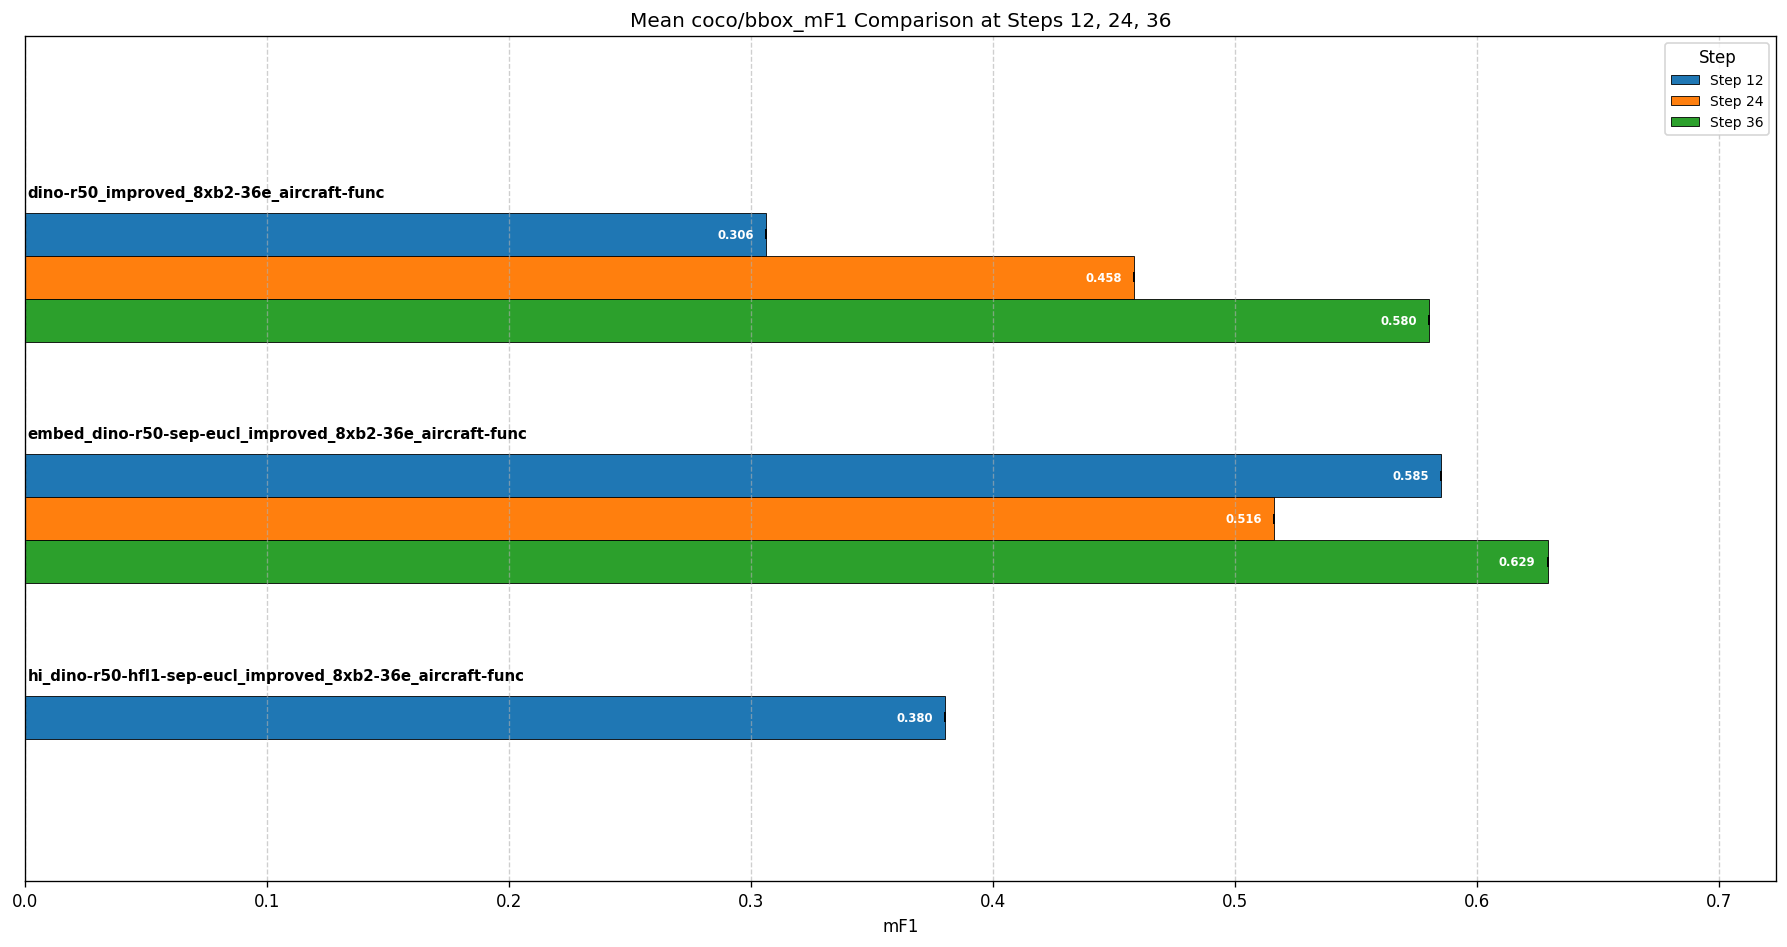

In [ ]:
# Example usage of the new plot_f1_comparison function
experiment_dirs_to_compare = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
]
plot_f1_comparison(
    experiment_dirs=experiment_dirs_to_compare,
    f1_key="coco/bbox_mF1",
    target_steps=[12, 24, 36],
    figsize=(15, 8),
    show=True
)

In [ ]:
import os
import glob
from pathlib import Path
import json, matplotlib.pyplot as plt, numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple, Union, Sequence, Optional

def plot_precision_recall_comparison(
    experiment_dirs: Sequence[Union[str, Path]],
    map_key: str = "coco/bbox_mAP",
    mar_key: str = "coco/bbox_AR@100",
    target_steps: Tuple[int, ...] = (12, 24, 36),
    step_key_preference: str = "epoch",
    log_labels: Optional[Union[List[str], Dict[Union[str, Path], str]]] = None,
    show: bool = True,
    save_path: Optional[Union[str, Path]] = None,
    dpi: int = 120,
    figsize: Tuple[float, float] = (10, 7),
):
    """
    Scatter-plots mAP (x-axis) against mAR (y-axis) for a set of experiment directories.
    For each directory, it calculates the mean and std dev of metrics over multiple runs.

    Parameters
    ----------
    experiment_dirs : sequence of str or Path
        Directories containing experiment runs. Each subdirectory with a timestamp is a run.
    map_key, mar_key : str
        Keys to look up in each JSON line for mAP and mAR.
    target_steps : iterable of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    log_labels : list/tuple OR dict OR None
        Custom labels for experiments. If None, directory names are used.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here.
    dpi : int
        DPI for the saved/shown figure.
    figsize : tuple
        Figure size.
    """

    # ---------- helper to resolve a label for a directory --------------------
    def _label_for(idx: int, d: Union[str, Path]) -> str:
        d_path = Path(d)
        if log_labels is None:
            return d_path.name
        if isinstance(log_labels, (list, tuple)):
            try:
                return log_labels[idx]
            except IndexError:
                return d_path.name
        # dict-like
        return log_labels.get(d, log_labels.get(d_path.name, d_path.name))

    # ---------- collect points -----------------------------------------------
    target_steps_set = set(target_steps)
    stats_data = defaultdict(lambda: {s: {'map': [], 'mar': []} for s in target_steps_set})

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        exp_dir_path = Path(exp_dir)
        log_files = list(exp_dir_path.glob('*/vis_data/scalars.json'))
        if not log_files:
            print(f"[WARN] No log files found in subdirectories of {exp_dir}")
            continue

        for file_path in log_files:
            found_in_file: Dict[int, Dict[str, float]] = {s: {} for s in target_steps_set}
            try:
                with file_path.open() as fh:
                    for line in fh:
                        try:
                            rec = json.loads(line)
                        except json.JSONDecodeError:
                            continue

                        step_val = rec.get(step_key_preference) or rec.get("epoch") or rec.get("step")
                        if step_val not in target_steps_set:
                            continue

                        if map_key in rec:
                            found_in_file[step_val][map_key] = rec[map_key]
                        if mar_key in rec:
                            found_in_file[step_val][mar_key] = rec[mar_key]
            except FileNotFoundError:
                continue

            for s in target_steps_set:
                if map_key in found_in_file[s] and mar_key in found_in_file[s]:
                    stats_data[dir_idx][s]['map'].append(found_in_file[s][map_key])
                    stats_data[dir_idx][s]['mar'].append(found_in_file[s][mar_key])

    # ---------- plotting -----------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    n_dirs = len(experiment_dirs)
    cmap = plt.cm.get_cmap("tab10")
    unique_steps = sorted(list(target_steps_set))
    markers = ["o", "s", "^", "D", "P", "X", "*", "v"]
    marker_for_step = {s: markers[i % len(markers)] for i, s in enumerate(unique_steps)}

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        if dir_idx not in stats_data:
            continue

        line_points = []
        for step in unique_steps:
            map_vals = stats_data[dir_idx][step]['map']
            mar_vals = stats_data[dir_idx][step]['mar']

            if not map_vals or not mar_vals:
                continue

            mean_map, std_map = np.mean(map_vals), np.std(map_vals)
            mean_mar, std_mar = np.mean(mar_vals), np.std(mar_vals)

            ax.errorbar(mean_map, mean_mar, xerr=std_map, yerr=std_mar,
                        marker=marker_for_step[step],
                        markersize=8,
                        color=cmap(dir_idx),
                        capsize=3,
                        linestyle='None',
                        elinewidth=1,
                        alpha=0.8,
                        zorder=5)
            line_points.append({'map': mean_map, 'mar': mean_mar, 'step': step})

        if line_points:
            line_points.sort(key=lambda p: p['step'])
            xs = [p['map'] for p in line_points]
            ys = [p['mar'] for p in line_points]

            ax.plot(xs, ys, linestyle="-", linewidth=1.0, alpha=0.3,
                    color=cmap(dir_idx), zorder=1)

    # -----------------------------------------------------------------------
    # ░░ Draw iso‑F1 (or Fβ) lines behind everything ░░
    # -----------------------------------------------------------------------
    f_levels = [0.3, 0.4, 0.5, 0.6, 0.7]        # tweak as you like
    ax.autoscale(enable=True, axis='both', tight=False)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x_vals = np.linspace(xmin, xmax, 400)

    for F in f_levels:
        # domain starts at P = F/2
        p = x_vals[x_vals > F / 2 + 1e-6]
        r = (F * p) / (2 * p - F)

        # keep points that land inside current y‑axis limits
        ymask = (r >= ymin) & (r <= ymax)
        ax.plot(
            p[ymask],
            r[ymask],
            linestyle="--",
            linewidth=0.8,
            color="grey",
            alpha=0.4,
            zorder=0,           # far behind markers/lines
        )
        # label the curve on the right edge
        if ymask.any():
            ax.text(
                p[ymask][-1],
                r[ymask][-1],
                f"F1={F:.1f}",
                fontsize=8,
                color="grey",
                ha="left",
                va="center",
                alpha=0.6,
            )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # -------- legend by step (markers) -----------------------------------------
    step_handles = [
        plt.Line2D([0], [0], marker=marker_for_step[s], linestyle="",
                markersize=8, color="w", markeredgecolor="k")
        for s in unique_steps
    ]
    step_labels = [f"step {s}" for s in unique_steps]

    step_legend = ax.legend(
        step_handles,
        step_labels,
        title="Epoch Step",
        loc="best",
        fontsize="small",
    )
    ax.add_artist(step_legend)

    # -------- legend by experiment (colours) ------------------------------------
    exp_handles = [
        plt.Line2D([0], [0], linestyle="-", color=cmap(i))
        for i in range(n_dirs) if i in stats_data
    ]
    exp_labels = [_label_for(i, experiment_dirs[i]) for i in range(n_dirs) if i in stats_data]

    ax.legend(
        exp_handles,
        exp_labels,
        title="Experiment",
        loc="best",
        fontsize="small",
    )

    ax.set_xlabel(map_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_ylabel(mar_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"mAP vs mAR at steps {', '.join(map(str, unique_steps))}")
    ax.grid(True, linestyle="--", alpha=0.6)
    
    # Adjust layout to make room for the legend
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)


# Example usage:
# experiment_dirs_to_compare = [
#     "../work_dirs/dino-4scale_r50_improved_8xb2",
#     "../work_dirs/frozen-4scale_r50_improved_8xb2"
# ]
#
# plot_precision_recall_comparison(
#     experiment_dirs=experiment_dirs_to_compare,
#     target_steps=[12, 24, 36],
# )

/tmp/ipykernel_750/542867663.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


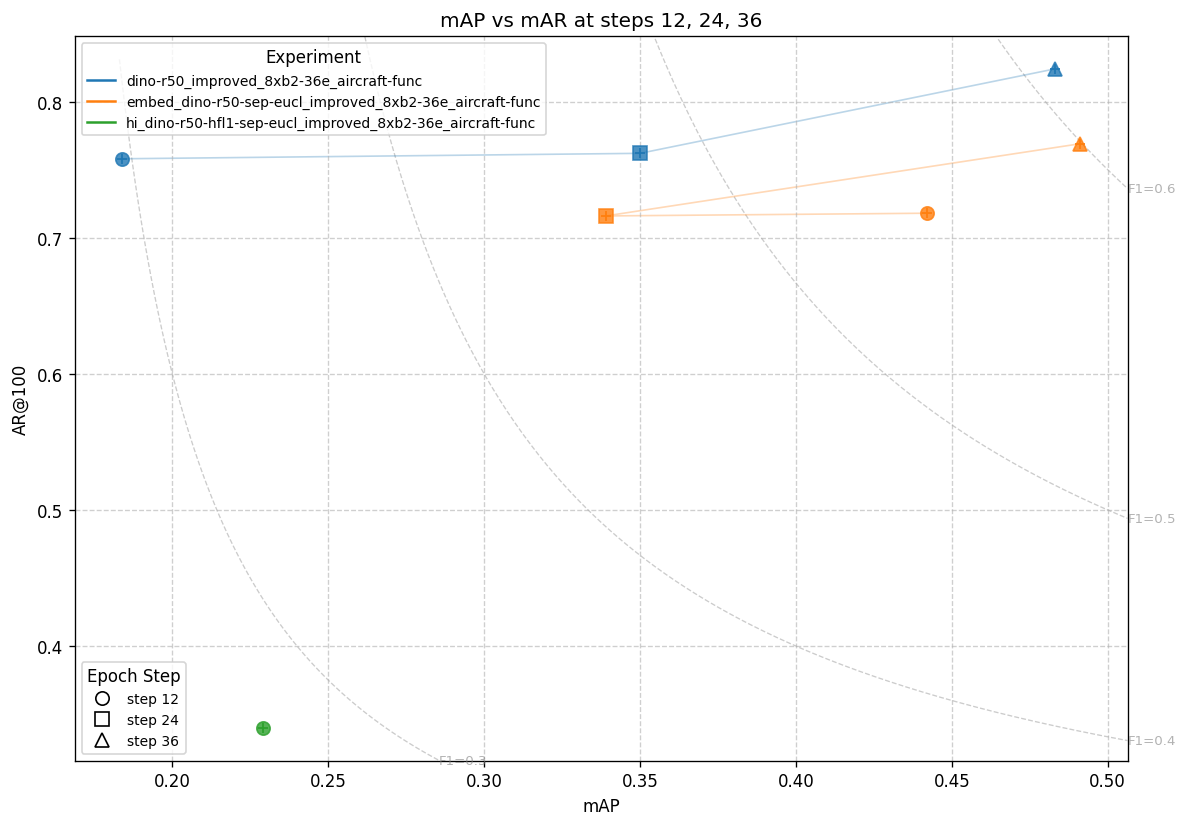

In [ ]:
experiment_dirs_to_compare = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
]
plot_precision_recall_comparison(
    experiment_dirs=experiment_dirs_to_compare,
    target_steps=[12, 24, 36],
)